In [123]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy.integrate import quad
import pandas as pd

## Exercice 1

### Question 2

Je génère la variable aléatoire X comme décrit dans la question 1.

In [124]:
def generate(X, P):
    u = np.random.rand(1)
    n = len(X)
    
    p = P[0]
    cumulative_sum = np.zeros(n)
    cumulative_sum[0] = p
    for i in range(1, n):
        p += P[i]
        cumulative_sum[i] = p
    
    k = np.argmax(cumulative_sum > u)

    return X[k]


### Question 3

Pour $n=4$ valeurs prises par $X$, et des probabilités $p$ explicités ci-dessous, je génère $N=1000$ valeurs de $X$.

L'histogramme représente en orange la distribution théorique, c'est-à-dire que la hauteur pour chaque valeur $x_i$ correspond exactement à se probabilité $p_i$. En bleu, on retrouve la distribution empirique. Les deux couleurs se superposent : la génération de $X$ correspond donc bien à la loi attendue.

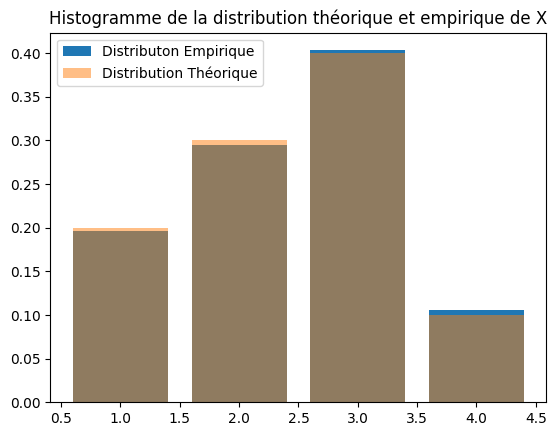

In [125]:
X = [1, 2, 3, 4]
P = [0.2, 0.3, 0.4, 0.1]

N = 1000

X_empirical = [generate(X, P) for i in range(N)]
hist, bin_edges = np.histogram(X_empirical, bins=len(X))
hist = hist / N

plt.figure()
plt.bar(X, hist, label='Distributon Empirique')
plt.bar(X, P, label='Distribution Théorique', alpha = 0.5)
plt.legend()
plt.title('Histogramme de la distribution théorique et empirique de X')
plt.show()



## Exercice 2

### Question 2

In [126]:
def generate_gaussian_mixt(n, m, d, P, Mu, Sigma):
    x = np.zeros((n, d))
    gauss = np.zeros(n)
    for i in range(n):
        gauss_index = generate(np.arange(m), P) # On choisit selon la proba P l'indice de la gaussienne
        x[i] = np.random.multivariate_normal(Mu[gauss_index,:], Sigma[gauss_index,:,:]) # On génère x selon la loi gaussienne choisie
        gauss[i] = gauss_index
    return x, gauss

In [127]:
d = 2 # Dimension 2 pour afficher les résultats dans le plan
m = 4
n = 10000

P = [0.4, 0.1, 0.2, 0.3] # correspondent aux probas de tirer chaque gaussienne dans la GM

Mu = np.array([[-5,5], [5,5], [-5,-5], [5,-5]]) # Moyenne des m=4 Gaussiennes

Sigma = np.random.rand(m,d,d) # Covariance : sous cette forme, n'est pas symétrique positive
Sigma = Sigma * Sigma.transpose([0,2,1]) + 3*np.tile(np.eye(d,d),reps=(m,1,1)) # symétrique positive

X, Gauss = generate_gaussian_mixt(n, m, d, P, Mu, Sigma)


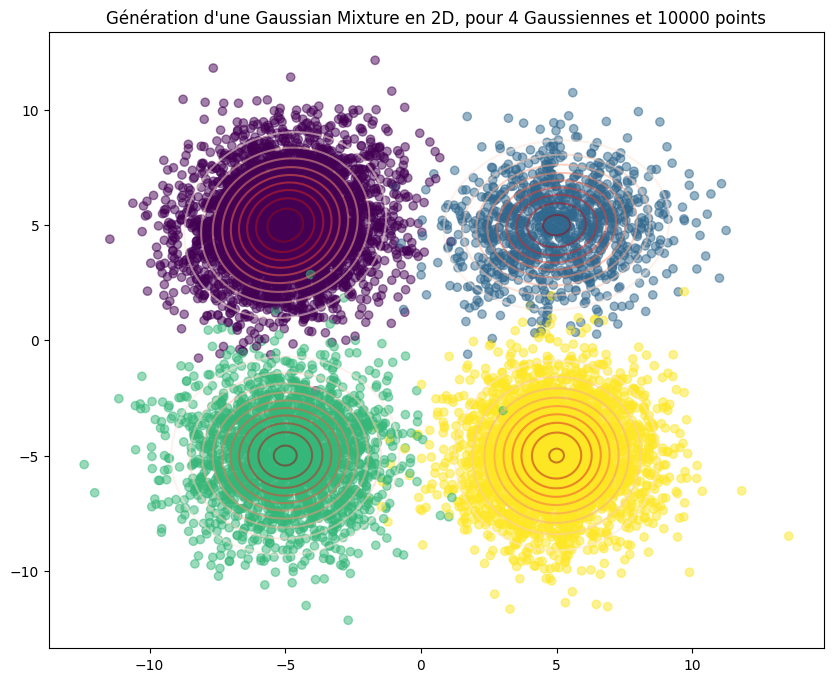

In [128]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=Gauss, cmap='viridis', alpha=0.5, label='Génération empirique')

x, y = np.mgrid[-10:10:.1, -10:10:.1]
data = np.dstack((x, y))

for i in range(m):
    rv = multivariate_normal(Mu[i, :], Sigma[i, :, :])
    z = rv.pdf(data)
    plt.contour(x, y, z, levels=10, cmap='Reds', alpha=0.5) # trace les contours pour chaque gaussienne

plt.title('Génération d\'une Gaussian Mixture en 2D, pour 4 Gaussiennes et 10000 points')
plt.show()

### Question 3

In [129]:
def log_likelyhood(X, Alpha, Mu, Sigma, m):
    n = len(X)
    density = np.array([multivariate_normal.pdf(X, Mu[j,:], Sigma[j,:,:]) for j in range(m)]) # Densités des Xi pour chaque Gaussienne (mu_j, sigma_j)
    F = np.zeros((n,m))
    for j in range(m):
        F[:,j] = Alpha[j]*density[j,:]
    return np.sum(np.log(np.sum(F, axis = 1) + 0.001)) # L'ajout du 0.001 permet de ne pas avoir de 0 dans le log

In [130]:
def EM(X, d, m, n_iter, eps):
    n = len(X)
    loglikelyhood = np.zeros(n_iter)

    # Initialisation des paramètres theta:
    Mu = np.array([10*(2*np.random.rand(d)-1) for _ in range(m)])
    Sigma = np.random.rand(m,d,d) 
    Sigma = Sigma * Sigma.transpose([0,2,1]) + 3*np.tile(np.eye(d,d),reps=(m,1,1))
    Alpha = np.ones(m)/m # proba initiale fixée à 1/m

    for t in range(n_iter):
        #########
        # E step
        #########
        log_T = np.zeros((n, m)) # Je passe par les log car les valeurs sont trop proches de 0
        for j in range(m):
            sign, logdet = np.linalg.slogdet(Sigma[j,:,:])
            inv_Sigma = np.linalg.pinv(Sigma[j,:,:])
            exposent = np.array([- (X[i,:]-Mu[j,:]).T @ inv_Sigma @ (X[i,:]-Mu[j,:]) / 2 for i in range(n) ])
            log_T[:, j] = np.log(Alpha[j]) - 0.5 * sign * logdet - d * np.log(2*np.pi)/2  + exposent
        T = np.exp(log_T - logsumexp(log_T, axis=1).reshape(n, 1)) # pJe renormalise T

        #########
        # M step
        #########
        Alpha = np.sum(T, axis = 0)/n
        for j in range(m):
            Mu[j] = np.dot(T[:, j], X) / (n*Alpha[j])
            Sigma[j] = ((T[:, j] * (X - Mu[j]).T )@ (X - Mu[j])) / (n*Alpha[j]) + eps*np.eye(d) # Le dernier terme assure la positivité de la covariance
        #loglikelyhood[t] = log_likelyhood(X, Alpha, Mu, Sigma, m, d)
        loglikelyhood[t] = log_likelyhood(X, Alpha, Mu, Sigma, m)

    return(Alpha, Mu, Sigma, loglikelyhood)
  

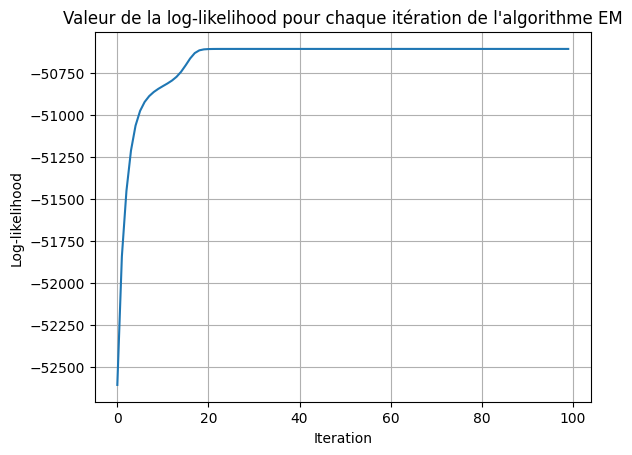

In [131]:
n_iter = 100
Alpha_est, Mu_est, Sigma_est, loglikelyhood = EM(X, d, m, n_iter, eps=0.01)

plt.figure()
plt.plot(loglikelyhood)
plt.title("Valeur de la log-likelihood pour chaque itération de l'algorithme EM")
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
plt.show()

## Question 4

In [132]:
'''
print('Alpha théorique :')
print(P)
print('Alpha estimé :')
print(Alpha_est)

print('Mu théorique :')
print(Mu)
print('Mu estimé :')
print(Mu_est)

print('Sigma théorique :')
print(Sigma)
print('Sigma estimé :')
print(Sigma_est)
'''

"\nprint('Alpha théorique :')\nprint(P)\nprint('Alpha estimé :')\nprint(Alpha_est)\n\nprint('Mu théorique :')\nprint(Mu)\nprint('Mu estimé :')\nprint(Mu_est)\n\nprint('Sigma théorique :')\nprint(Sigma)\nprint('Sigma estimé :')\nprint(Sigma_est)\n"

Si j'affiche directement les résultats obtenus pour $Alpha_{est}$, $Mu_{est}$ et $Sigma_{est}$, j'obtiens des valeurs similaires à celles attendues, mais pas dans le "bon ordre", car l'algorithme EM a détecté les paramètres des clusters indépendemment de leur ordre dans la définition des paramètres théoriques

Pour comparer les résultats obtenus avec les résultats théoriques, je retrouve d'abord à quels paramètres initiaux l les paramètres estimés $alpha_j$, $mu_j$, $sigma_j$ correspondent.

Ensuite, j'affiche les trois paramètres ainsi que la distance entre les valeurs théoriques et estimées.

In [133]:
# Je retrouve quels paramètres estimés correspondent à quels paramètres originaux
Mu_est = np.array(Mu_est)
Mu = np.array(Mu)
Sigma_est = np.array(Sigma_est)
Sigma = np.array(Sigma)

pairs = np.zeros(m, dtype=int)  # initialisation avec tableau NumPy
for j in range(m):
    pairs[j] = np.argmin([np.linalg.norm(Mu_est[l, :] - Mu[j, :]) for l in range(m)])
    

Alpha_est = [Alpha_est[pairs[j]] for j in range(m)]
Mu_est = [Mu_est[pairs[j],:] for j in range(m)]
Sigma_est = [Sigma_est[pairs[j],:,:] for j in range(m)]

print('Alpha théorique :')
print(P)
print('Alpha estimé :')
print([float(a) for a in Alpha_est])
print("Distance entre les distributions théoriques et estimées :", np.linalg.norm(Alpha_est - np.array(P)))
print()

print('Mu théorique :')
print(Mu)
print('Mu estimé :')
print([mu.tolist() for mu in Mu_est])
print("Distance entre les moyennes théoriques et estimées :", np.linalg.norm(Mu_est - Mu, axis = 1))
print()

print('Sigma théorique :')
print(Sigma)
print('Sigma estimé :')
print(Sigma_est)
print("Distance entre les matrices de covariance théoriques et estimées :", np.linalg.norm(Sigma_est - Sigma, axis = (1,2)))
print()


Alpha théorique :
[0.4, 0.1, 0.2, 0.3]
Alpha estimé :
[0.3954177467295693, 0.10049863172997353, 0.20313797486504034, 0.30094564667541435]
Distance entre les distributions théoriques et estimées : 0.005655688510239622

Mu théorique :
[[-5  5]
 [ 5  5]
 [-5 -5]
 [ 5 -5]]
Mu estimé :
[[-4.9881359573208135, 5.096769555623159], [4.981185190453302, 4.888282188307016], [-4.950469831915548, -5.020599518843504], [4.994598242415762, -5.020008129805048]]
Distance entre les moyennes théoriques et estimées : [0.09749411 0.11329107 0.05364306 0.02072448]

Sigma théorique :
[[[3.04726531 0.31372834]
  [0.31372834 3.58707839]]

 [[3.8659303  0.21423818]
  [0.21423818 3.04355715]]

 [[3.79525038 0.05327313]
  [0.05327313 3.97687201]]

 [[3.18136915 0.03992895]
  [0.03992895 3.83843311]]]
Sigma estimé :
[array([[3.15548006, 0.31064657],
       [0.31064657, 3.54987713]]), array([[4.1240488 , 0.29468395],
       [0.29468395, 3.25719254]]), array([[ 3.80213413, -0.03825871],
       [-0.03825871,  3.8858048

On remarque bien que les valeurs estimées sont proches de celles attendues. Par exemple pour les probabilités $alpha_j$, on obtient $[0.395, 0.100, 0.203, 0.301]$ et était attendu $[0.4, 0.1, 0.2, 0.3]$. 

## Question 5

C:\Users\roman\AppData\Local\Temp\ipykernel_3724\1096322784.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('WPP2024_Demographic_Indicators_Medium.csv')[['CBR','CDR']]


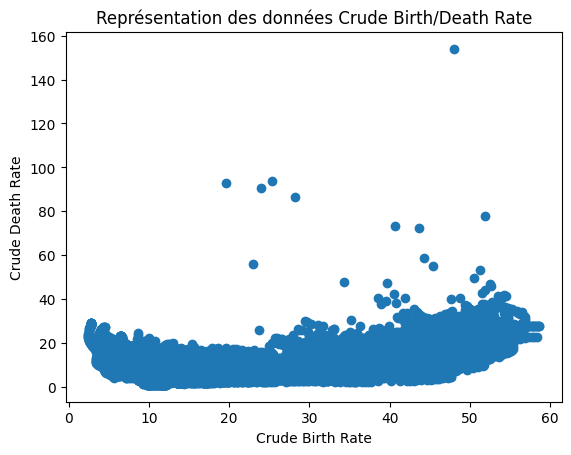

In [134]:
data = pd.read_csv('WPP2024_Demographic_Indicators_Medium.csv')[['CBR','CDR']]
data = data.replace([np.inf, -np.inf], np.nan).dropna()
plt.figure()
plt.scatter(data['CBR'],data['CDR'])
plt.title("Représentation des données Crude Birth/Death Rate")
plt.xlabel('Crude Birth Rate')
plt.ylabel('Crude Death Rate')
plt.show()


La distribution est assez étalée. On ne voit pas apparaître de cluster, mais ils peuvent se superposer. Le modèle de Gaussian Mixture pourrait mettre en évidence des clusters (potentiellement diffus).

## Question 6

In [135]:
# Critère BIC défini dans l'énoncé
def BIC_criterion(log_likelihood, n, m, d):
    df_m = m * (d*(d+1)//2 + d) + m # Symetric covariance matrix d*(d+1)//2 + alpha m
    return -log_likelihood + np.log(n)*df_m/2

m = 1
BIC = 225391.8085007224


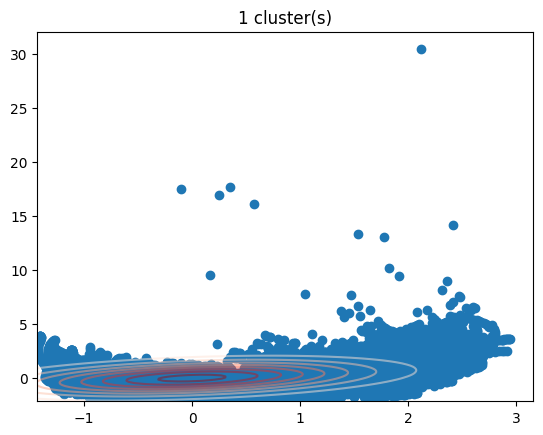

m = 2
BIC = 171973.30428593885


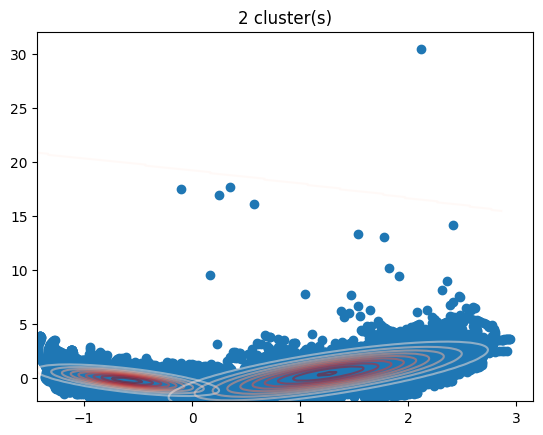

m = 3
BIC = 159074.44858508446


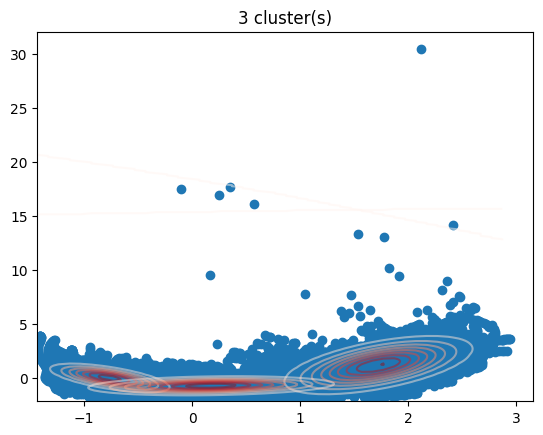

m = 4
BIC = 156231.42666791755


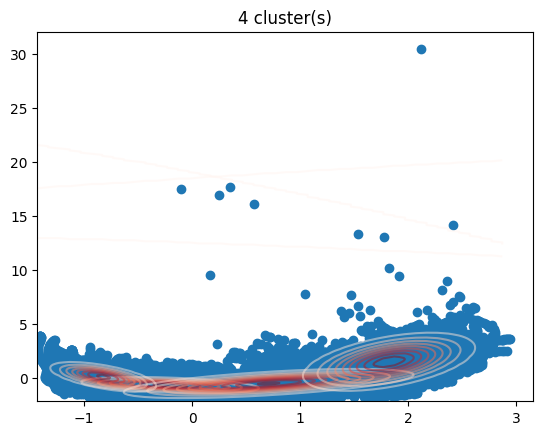

m = 5
BIC = 155647.16786250818


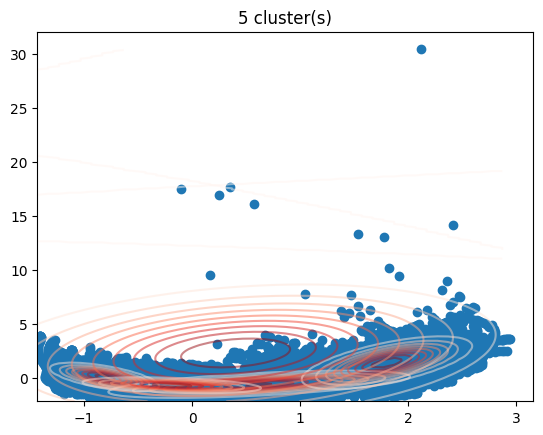

m = 6
BIC = 155715.40847575496


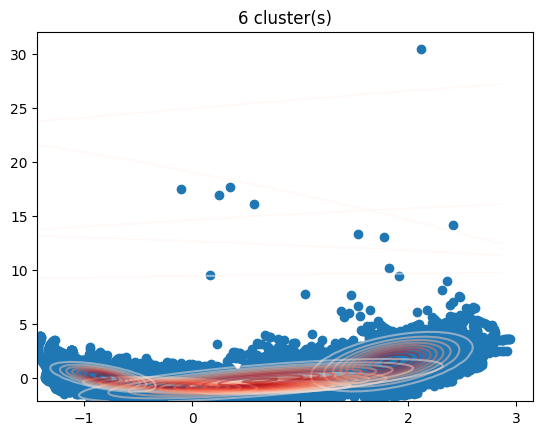

m = 7
BIC = 155745.91600791417


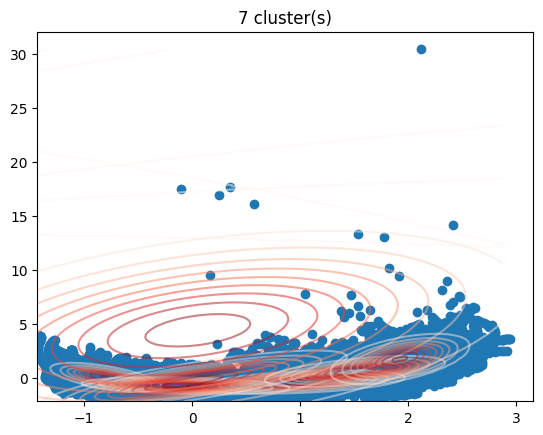

m = 8
BIC = 154712.4132778672


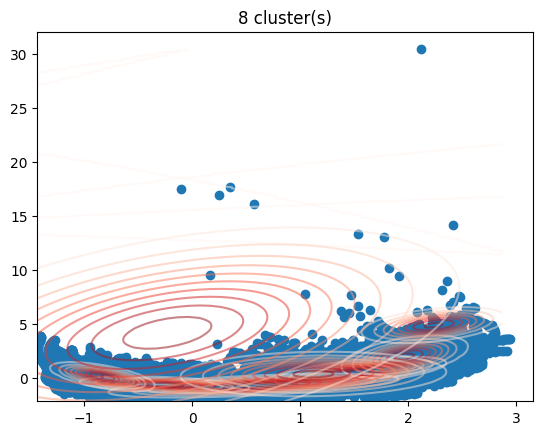

m = 9
BIC = 154322.47379522788


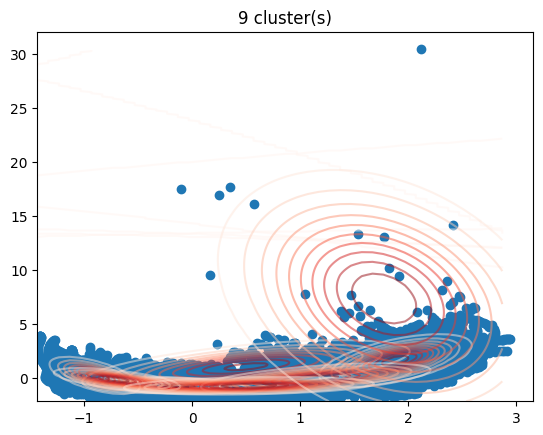

m = 10
BIC = 154627.4722589072


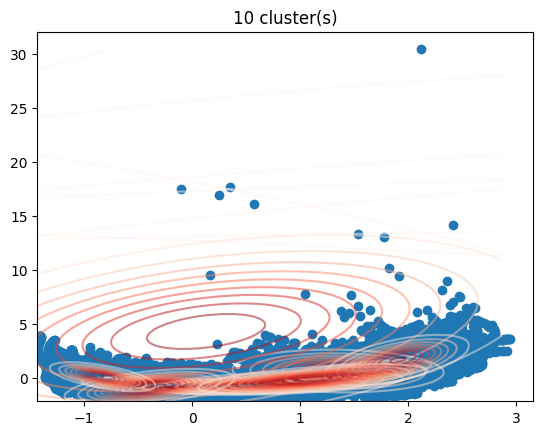

m = 11
BIC = 154653.9200772453


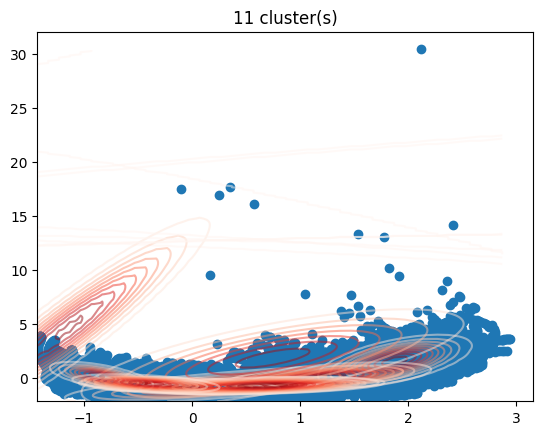

m = 12
BIC = 154989.61516882954


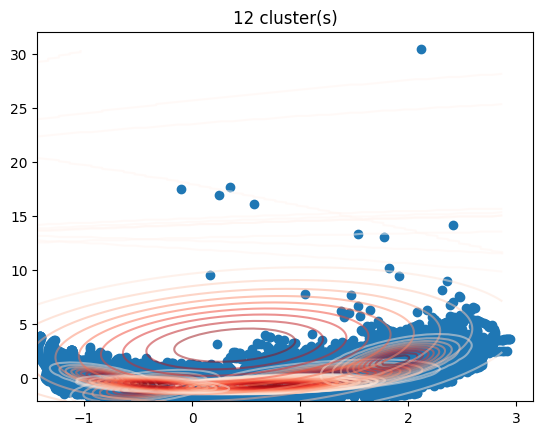

m = 13
BIC = 152994.52590968605


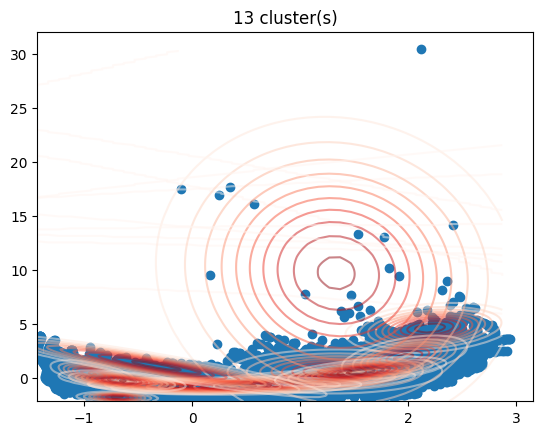

m = 14
BIC = 153616.0156486486


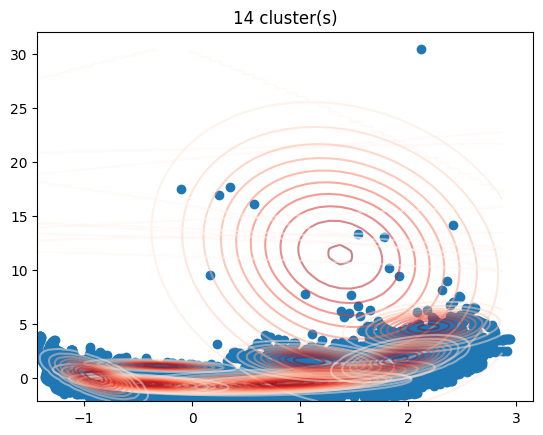

m = 15
BIC = 153273.77627291027


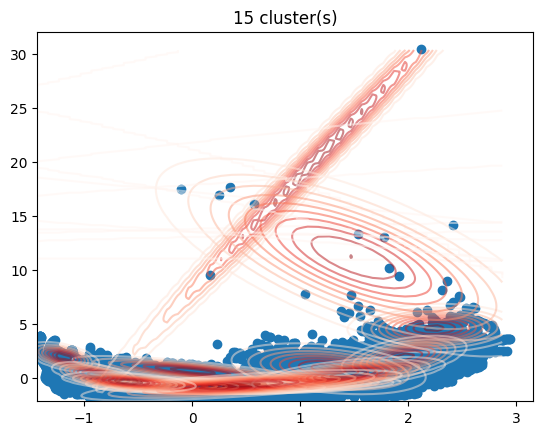

In [136]:
n_iter = 100
X = data.to_numpy()
x_norm = (X - np.mean(X, axis=0))/np.std(X, axis=0) # Renormalisation des données
n,d = X.shape
BIC = np.zeros(15) # Test pour 15 valeurs de m

for m in range(1, 16):
    Alpha_est, Mu_est, Sigma_est, list_logl = EM(x_norm, d, m, n_iter, eps=0.01)
    log_likelihood  = list_logl[-1]
    BIC[m-1] = BIC_criterion(log_likelihood, n, m, d)
    print('m =', m )
    print('BIC =', BIC[m-1])

    plt.figure()
    plt.scatter(x_norm[:,0],x_norm[:,1])
    x, y = np.mgrid[np.min(x_norm[:,0]):np.max(x_norm[:,0]):.1, np.min(x_norm[:,1]):np.max(x_norm[:,1]):.1]
    data = np.dstack((x, y))

    # On affiche les pdf des m clusters (les contours)
    for i in range(m):
        rv = multivariate_normal(Mu_est[i, :], Sigma_est[i, :, :])
        z = rv.pdf(data)
        plt.contour(x, y, z, levels=10, cmap='Reds', alpha=0.5) # trace les contours pour chaque gaussienne

    plt.title(f'{m} cluster(s)')
    plt.show()



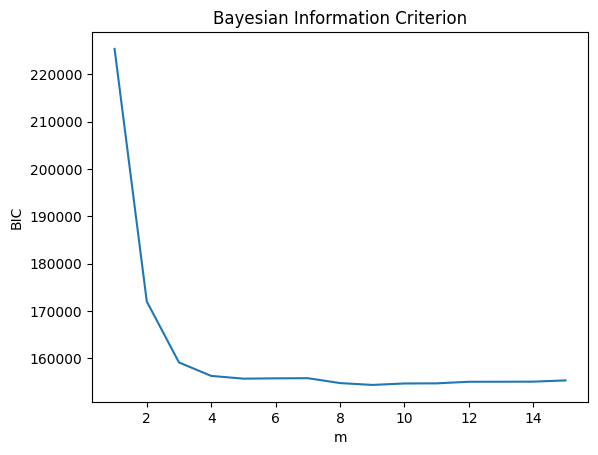

In [ ]:
# Afficher la valeur du BIC en fonction de m
plt.plot(range(1, 16), BIC[0:15])
plt.title('Bayesian Information Criterion')
plt.xlabel('m')
plt.ylabel('BIC')
plt.show()

# Exercise 3

## Question 1

In [138]:
def f(x):
    return(2*np.sin(np.pi*x/1.5)*(x>=0))

def p(x):
    return(x**(0.65)*np.exp(-x**2/2)*(x>=0))

def q(x, mu, sigma):
    return(2*np.exp(-(mu-x)**2/(2*sigma))/np.sqrt(2*np.pi*sigma))

In [139]:
def importance_sampling(f, p, q, mu, sigma, N):
    X = np.random.normal(mu, sigma, N)
    X = X * (X>=0) # On s'assure que X>=0
    W = p(X)/q(X, mu=mu, sigma=sigma)
    W_normalized = W/np.mean(W)
    return(np.sum(W_normalized.T@f(X))/N, W)

## Question 2

In [140]:
mu = 0.8
sigma = 1.5

exact_exp = quad(lambda x: p(x)*f(x), 0, np.inf)[0]
print("Valeur de l'espérance de f(X) attendue : E[f(X)] = ",exact_exp, '.\n')

for N in [10, 100, 1000, 10000]: # N donne le nombre de samples dans un test
    estimate = [importance_sampling(f, p, q, mu, sigma, N)[0] for i in range(10000)] # Pour chaque N, on fait 10000 tests pour avoir une moyenne/variance
    print("Taille N =", N)
    print("Moyenne de l'importance sampling de E[f(X)] :", np.round(np.mean(estimate), decimals=4))
    print("Variance de l'importance sampling de E[f(X)] :", np.round(np.std(estimate), decimals=4), '\n')

Valeur de l'espérance de f(X) attendue : E[f(X)] =  0.7752953044208202 .

Taille N = 10
Moyenne de l'importance sampling de E[f(X)] : 0.6469
Variance de l'importance sampling de E[f(X)] : 0.5356 

Taille N = 100
Moyenne de l'importance sampling de E[f(X)] : 0.678
Variance de l'importance sampling de E[f(X)] : 0.1577 

Taille N = 1000
Moyenne de l'importance sampling de E[f(X)] : 0.6821
Variance de l'importance sampling de E[f(X)] : 0.0496 

Taille N = 10000
Moyenne de l'importance sampling de E[f(X)] : 0.6832
Variance de l'importance sampling de E[f(X)] : 0.0158 



## Question 3

Pour N = 10000 , M = 10000 et mu =  0.8
Moyenne des importance weights = 0.4378
Variance des importance weights = 0.3766


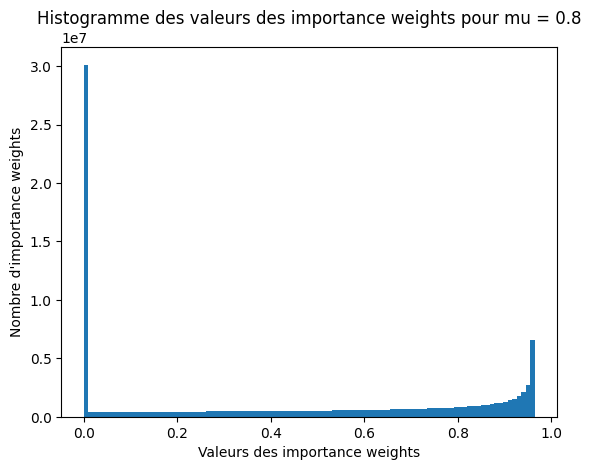

Pour N = 10000 , M = 10000 et mu =  6
Moyenne des importance weights = 7.5214
Variance des importance weights = 350.3391


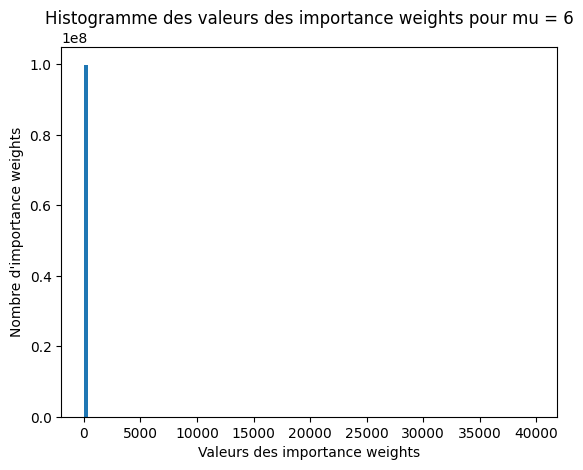

In [141]:
N = 10000 # Nombre de samples 
M = 10000 # Nombre de tests pour chaque mu

Mu = [0.8, 6]
sigma=1.5

for mu in Mu:
    W = np.array([importance_sampling(f, p, q, mu, sigma, N)[1] for i in range(M)])
    print('Pour N =', N, ', M =', M, 'et mu = ', mu)
    print('Moyenne des importance weights =', np.round(np.mean(W),decimals=4)) 
    print('Variance des importance weights =',np.round(np.std(W),decimals=4)) 
  
    plt.figure()
    plt.hist(W.flatten(), bins = 100)
    plt.title(f"Histogramme des valeurs des importance weights pour mu = {mu}")
    plt.xlabel("Valeurs des importance weights")
    plt.ylabel("Nombre d'importance weights")
    plt.show()

La valeur moyenne des poids pour $µ = 0.8%$ est entre $0.8$ et $1$, alors que pour $µ = 6%$, cette moyenne est plus élevée que $1$, de l'ordre de $7$. En revanche, la majorité des valeurs prises par les poids sont très proches de $0$ : la moyenne est biaisée par quelques valeurs très élevées. 

Les poids représentent le ratio entre les densités $p$ et $q$. Lorsque $µ = 6%$, on sample (avec $q$) dans une région où $p$ est proche de 0, et donc les poids sont très faibles. En revanche, les quelques fois où $q$ est faible, on a au contraire des valeurs élevées de $p/q$. Il est plus judicieux de choisir $µ$ de sorte à ce que les distributions soient alignées (davantage le cas ici lorsque $µ = 0.8$ par rapport au cas où $µ = 6$).

## Question 5

In [142]:
# Banana density

def banana_density(x, d, b, sigma1):
    Sigma = np.eye(d)
    Sigma[0,0] = sigma1**2
    point = x.copy()
    point[:,1] += b*(point[:,0]**2 - sigma1**2) 
    return multivariate_normal.pdf(point,np.zeros(d),Sigma,N)

# Génère N samples selon la banana density
def banana_sampler(d, b, sigma1, N):
    Sigma = np.eye(d)
    Sigma[0,0] = sigma1**2
    sample = np.random.multivariate_normal(np.zeros(d),Sigma,N)
    sample[:,1] += b*(sample[:,0]**2 - sigma1**2)  
    return sample


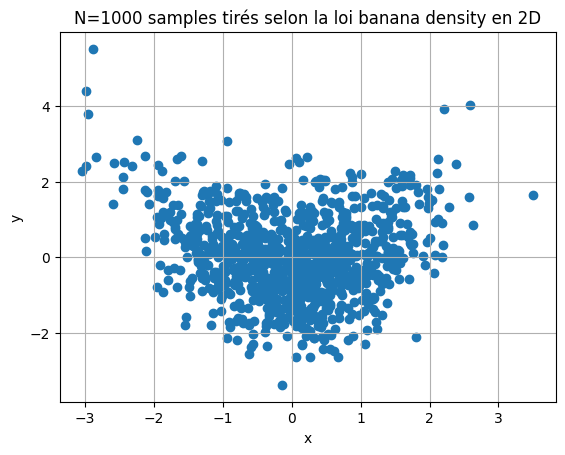

In [143]:
# Affichage de la génération selon banana density

N = 1000
d = 2
b = 0.4
sigma1 = 1

data = banana_sampler(d, b, sigma1, N)
plt.figure()
plt.scatter(data[:,0],data[:,1])
plt.grid()
plt.title("N=1000 samples tirés selon la loi banana density en 2D" )
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [144]:
# Gaussian Mixture Model

def GMM(m, n, x, alpha_t, mu_t, Sigma_t) : 
    GMM = np.zeros(n)
    for j in range(m):
        GMM += alpha_t[j] * multivariate_normal.pdf(x, mu_t[j,:], Sigma_t[j,:,:])    
    return GMM


In [145]:
def omega(X, d, alpha, mu, Sigma, b, sigma1):
    
    m = len(alpha)
    n = X.shape[0]
    
    P = banana_density(X, d, b, sigma1)
    Q = GMM(m, n, X, alpha, mu, Sigma)
    omega = P/Q 
    return omega

In [146]:
# Algorithme EM avec Adaptive Importance Sampling
def EM_with_AIS(n, d, m, b, sigma1, n_iter, eps, theta = None):

    # Initialisation 
    if theta is None:
        Mu = np.random.rand(m,d)*2
        Sigma = np.random.rand(m,d,d)
        Sigma = Sigma@Sigma.transpose([0,2,1]) + eps * np.tile(np.eye(d,d),reps=(m,1,1)) # Définit une matrice symétrique positive
        Alpha = np.ones(m)
        Alpha /= Alpha.sum() 
    else:
        Alpha, Mu, Sigma = theta
    
    # Algorithme EM
    for t in range(n_iter):
        X, gauss = generate_gaussian_mixt(n, m, d, Alpha, Mu, Sigma)
        
        #########
        # E step
        #########
        log_T = np.zeros((n, m)) # Je passe par les log car les valeurs sont trop proches de 0
        for j in range(m):
            sign, logdet = np.linalg.slogdet(Sigma[j,:,:])
            inv_Sigma = np.linalg.pinv(Sigma[j,:,:])
            exposent = np.array([- (X[i,:]-Mu[j,:]).T @ inv_Sigma @ (X[i,:]-Mu[j,:]) / 2 for i in range(n) ])
            log_T[:, j] = np.log(Alpha[j]) - 0.5 * sign * logdet - d * np.log(2*np.pi)/2  + exposent
        T = np.exp(log_T - logsumexp(log_T, axis=1).reshape(n, 1)) # pJe renormalise T

        #########
        # M step
        #########
        W = omega(X, d, Alpha, Mu, Sigma, b, sigma1)
        sum_W_T = np.sum(T*np.tile(W,reps=(m,1)).T, axis = 0) # Somme sur i des Wi*Tij pour chaque j

        Alpha = sum_W_T/np.sum(W*np.sum(T,axis=1))
        for j in range(m):
            Mu[j,:] = (W*T[:,j]).T@X/sum_W_T[j]
            Sigma[j,:,:] =(T[:,j]* W *(X - Mu[j,:]).T@(X - Mu[j,:]))/sum_W_T[j]+ eps * np.eye(d,d)

    return(Alpha, Mu, Sigma)
        


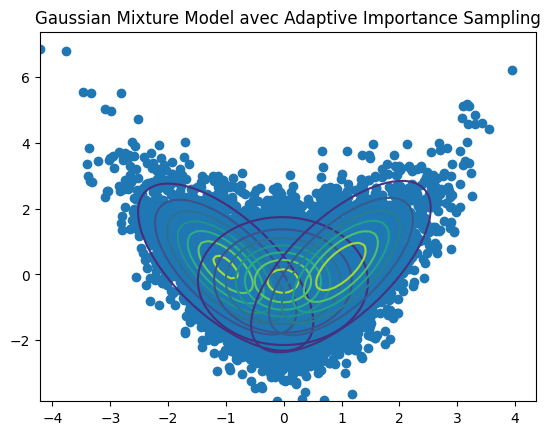

In [147]:
N = 10000
d = 5
m = 3
b = 0.4
sigma1 = 1
n_iter = 100
eps = 0.01

data = banana_sampler(d, b, sigma1, N)
Alpha, Mu, Sigma  = EM_with_AIS(N, d, m, b, sigma1, n_iter, eps)

plt.figure()
plt.title('Gaussian Mixture Model avec Adaptive Importance Sampling')
plt.scatter(data[:,0],data[:,1]) # On projète sur les deux premières dimensions
x, y = np.mgrid[np.min(data[:,0]):np.max(data[:,0]):.1, np.min(data[:,1]):np.max(data[:,1]):.1]
data = np.dstack((x, y))
for i in range(m):
    rv = multivariate_normal(Mu[i,:2], Sigma[i,:2,:2])
    z = rv.pdf(-data)
    plt.contour(x, y, z)
plt.show()